In [3]:
!cp /content/drive/MyDrive/ashrae.zip ashrae.zip
!unzip -q ashrae.zip

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import gc 

In [5]:
train = pd.read_csv('train.csv')
weather_train = pd.read_csv('weather_train.csv')
build_meta = pd.read_csv('building_metadata.csv') 

In [ ]:
train['timestamp'] = pd.to_datetime(train['timestamp']) 

train['meter'] = train['meter'].map({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
train.loc[(train.meter == 'electricity'),'meter_reading'] = train['meter_reading'] * 0.2931 # conversion from kwh to kbtu

train['log_meter_reading'] = np.log(train['meter_reading'] + 1 )

build_meta_f = build_meta.copy()

#fill all the missing floor counts by the mode (1) and the missing year built by the mean. Nothing else is missing
build_meta_f.fillna({'floor_count':1, 'year_built':int(build_meta['year_built'].mean())}, inplace=True)

#this is the only categorical column. Convert so it can be handled later by lgbm during fitting
build_meta_f['primary_use'] = build_meta_f['primary_use'].astype('category') 

In [ ]:
weather_train_f = weather_train.copy() # make a copy so we aren't changing our oridinal data
weather_train_f['timestamp'] = pd.to_datetime(weather_train_f['timestamp']) # turn the timestamp column into a datetime object
weather_train_f = weather_train_f.sort_values(by=['site_id', 'timestamp']) # short values by site id then timestamp

weather_train_f.fillna(method = 'ffill', inplace=True, limit = 24) # forward fill the missing data up to 12 hours
weather_train_f.fillna(method = 'bfill', inplace=True, limit = 24) # backfill up to 12 hours

#Train data
missing_cols = [col for col in weather_train_f.columns if weather_train_f[col].isna().any()] 

#stores the mean of each feature for each site id
fill_lib = weather_train_f.groupby('site_id')[missing_cols].transform('mean')

#for each feature with missing values, fill the missing entry with the mean for that site
weather_train_f.fillna(fill_lib, inplace=True)

In [ ]:
train_m = train.merge(build_meta_f, how='left', on = ['building_id'], validate='many_to_one') # merge the building meta data into the train data
train_m = train_m.merge(weather_train_f, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')# add weather data to each time entry for each site ID

#we now delete some of the dataframes we no longer need to free up memory
del train, weather_train, weather_train_f , build_meta
gc.collect()

205

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
      print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_m = reduce_mem_usage(train_m)
gc.collect()

Mem. usage decreased to 1079.66 Mb (59.1% reduction)


0

In [ ]:
for col in train_m.columns:
  if train_m[col].isnull().values.any():
    print(col , ' contains', train_m[col].isnull().values.sum() , 'missing values ')
    print('----')
    imputation = train_m.groupby(['site_id'])[col].transform('mean')
    train_m[col].fillna(imputation,inplace = True)
print('Missing values replaced by the mean of the column')

air_temperature  contains 90495 missing values 
----
cloud_coverage  contains 90495 missing values 
----
dew_temperature  contains 90495 missing values 
----
precip_depth_1_hr  contains 90495 missing values 
----
sea_level_pressure  contains 90495 missing values 
----
wind_direction  contains 90495 missing values 
----
wind_speed  contains 90495 missing values 
----
Missing values replaced by the mean of the column


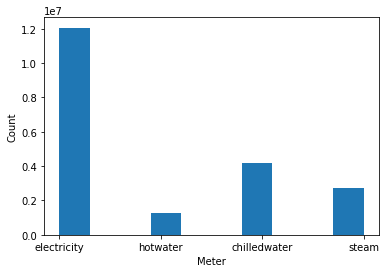

In [ ]:
plt.hist(train_m['meter'])
plt.xlabel('Meter')
plt.ylabel('Count')
plt.show()

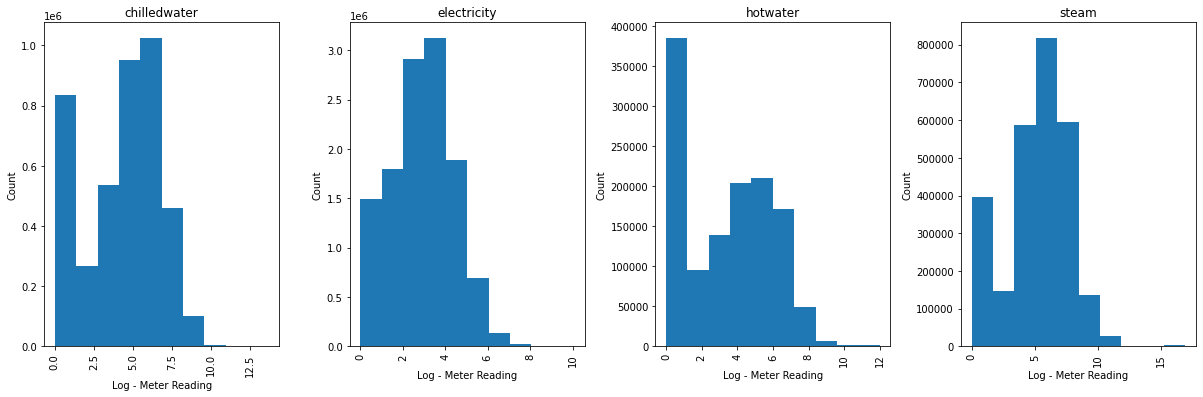

In [ ]:
ax = train_m.hist(column = 'log_meter_reading',by=train_m['meter'] , figsize=(20,6) , layout=(1,4) )
for axi in ax.reshape(-1):
  axi.set_xlabel("Log - Meter Reading")
  axi.set_ylabel("Count")
plt.show()

In [ ]:
train_m.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading',
       'log_meter_reading', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

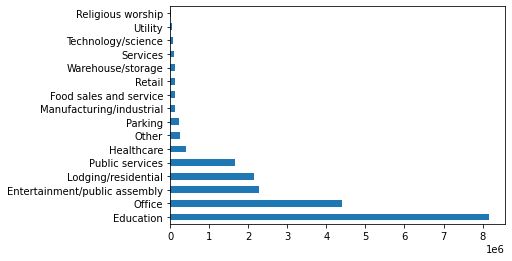

In [ ]:
train_m['primary_use'].value_counts().plot(kind='barh')
plt.show()

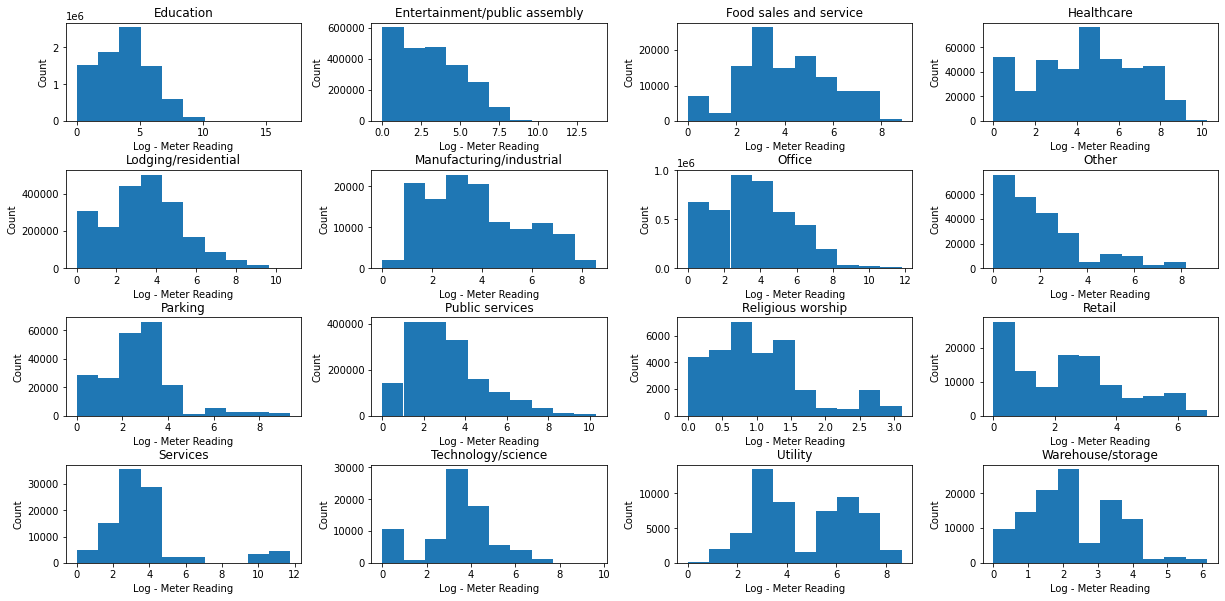

In [ ]:
ax = train_m.hist(column = 'log_meter_reading',by=train_m['primary_use'] , figsize=(20,10) ,xrot= 0)
for axi in ax.reshape(-1):
  axi.set_xlabel("Log - Meter Reading")
  axi.set_ylabel("Count")
plt.show()

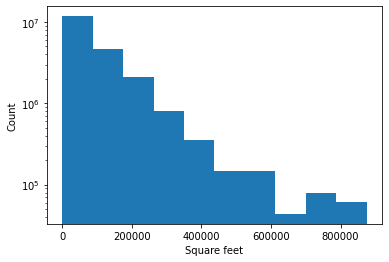

In [ ]:
plt.hist(train_m['square_feet'] , log=True)
plt.xlabel('Square feet')
plt.ylabel('Count')
plt.show()

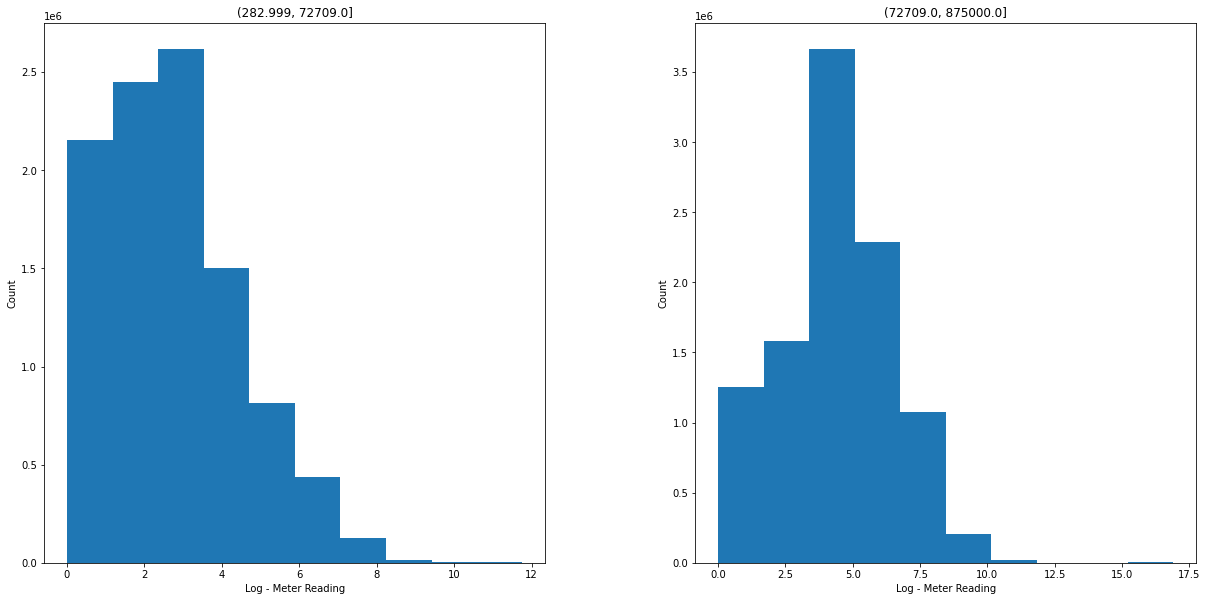

In [ ]:
###################
train_m['square_feet_categorical'] = pd.qcut(train_m['square_feet'], q=2) # 
###################
ax = train_m.hist(column = 'log_meter_reading',by=train_m['square_feet_categorical'] , figsize=(20,10) ,xrot= 0)
for axi in ax.reshape(-1):
  axi.set_xlabel("Log - Meter Reading")
  axi.set_ylabel("Count")
plt.show()

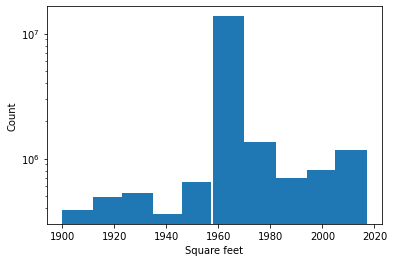

In [ ]:
plt.hist(train_m['year_built'] , log=True)
plt.xlabel('Square feet')
plt.ylabel('Count')
plt.show()

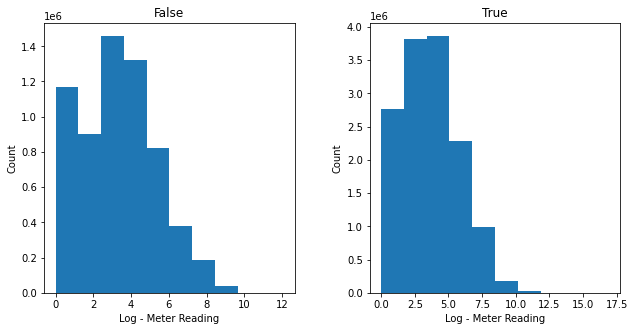

In [ ]:
train_m['year_built_cat'] = (train_m['year_built']< 1970) * (train_m['year_built']> 1955) # (1955 , 1970)
###################
ax = train_m.hist(column = 'log_meter_reading',by=train_m['year_built_cat'] , figsize=(10,5) ,xrot= 0)
for axi in ax:
  axi.set_xlabel("Log - Meter Reading")
  axi.set_ylabel("Count")
plt.show()

In [ ]:
train_m.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading',
       'log_meter_reading', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'square_feet_categorical',
       'year_built_cat'],
      dtype='object')

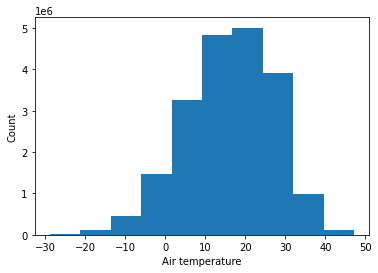

In [ ]:
plt.hist(train_m['air_temperature'])
plt.xlabel('Air temperature')
plt.ylabel('Count')
plt.show()

In [ ]:
from scipy import stats
stat,p = stats.shapiro(train_m['air_temperature'].values)

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
 
print('We can use this to remove outliers [mu-2*sigma , mu+2*sigma]')
mu = np.mean(train_m['air_temperature'].values)
sigma = (np.mean((train_m['air_temperature'].values - mu)**2))**0.5


print( 'mu = ',mu)
print( 'sigma = ',sigma)

Statistics=1.003, p=1.000
Sample looks Gaussian (fail to reject H0)
We can use this to remove outliers [mu-2*sigma , mu+2*sigma]
mu =  15.96
sigma =  10.928746497197197


In [ ]:
train_m = train_m.loc[(train_m['air_temperature'] < mu + 3*sigma) & (train_m['air_temperature'] > mu - 3*sigma)].shape

(20132922, 19)

nan

119.44

In [ ]:
train_m['air_temperature']

0           25.000000
1           25.000000
2           25.000000
3           25.000000
4           25.000000
              ...    
20216095     1.700195
20216096     1.700195
20216097     1.700195
20216098     1.700195
20216099     1.700195
Name: air_temperature, Length: 20216100, dtype: float16